# Anti-windup systems 

In this notebook we are going to review a simple implementation of anti-windup system for a PID controller based on the classical implementation from (Åstrom,Hägglund, 2005). For better understand the problem of anti-windup, it is useful to implement a regular first order model. 

In this case we consider the system: 

$$G_1(s) = \frac{1}{\tau s + 1}$$

Notice that when the system is excited with a step response, the classical answer is the solution of the ODE. In the following lines we consider a discretized version of the system, to analyze it's response. 

Notice that the system:

$$G_n(s) = \frac{1}{(\tau s + 1)^n}$$ 

Is an approximation of a delayed time system of the form 

$$G_d(s) = \frac{e^{-sd}}{(\tau s + 1)}$$ 

For algorithmic purposes we consider $G_d(s) \approx G_2(n)$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sympy import *
# import control as cnt
%matplotlib inline

Let's the fine the system constants such as sampling time `TS` and time constant `TAU`

In [2]:
TS = 0.1 # Sampling time
TAU = 10

In [3]:
class System:
    
    def __init__(self, K=1):
        self.x = [0]
        self.K = 1
        self.A = 10 # Constant time 
        self.T = TS # Sampling time
        self.t = [0]

    def update(self, control):
        """
            Update x_[k+1] as a function of x[k]
        """ 
        
        #  Dynamics first order approximation
        
        x_k = self.x[-1]-\
              self.x[-1]*self.T/self.A + \
              self.K *control*self.T/self.A
        
        self.x.append(x_k) # State 
        self.time_update()

    def time_update(self):
        """ time vector"""
        self.t.append(self.t[-1]+self.T)
    
    def __call__(self,control):
        """
            Use it like function 
        """
        self.update(control)
        return self.x[-1]
    

The system evolution can be easily computed in a for loop, in this case we consider $n =4 $

In [4]:
u = np.concatenate([np.zeros(10),np.ones(2000)])

g1,g2,g3,g4 = System(), System(),System(),System()

for ctr in u:
    g4(g3(g2(g1(ctr))))

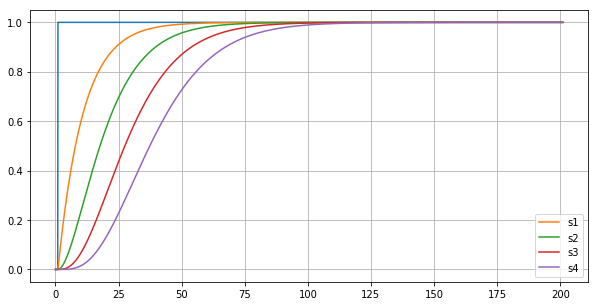

In [5]:
# Plot of step responses 
tu = np.arange(0,(len(u))*TS,TS)
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(tu,u);
ax.plot(g1.t,g1.x,label='s1');
ax.plot(g2.t,g2.x,label='s2');
ax.plot(g3.t,g3.x,label='s3');
ax.plot(g4.t,g4.x,label='s4');
ax.grid(True)
ax.legend();

## Implementation of derivative and integrals 

The following are two simple implementations of a derivative and an integral. The computations are intended for testing purposes. 

In [6]:
# %%writefile -a pid.py

class Derivator:
    def __init__(self):
        self.x = [0]
        self.dx = [0]
        self.T = TS 
        self.t = [0]
    
    def diff(self,val):
        """
            Compute (x_k - x_{k-1})/T and updates the memory 
        """
        dif = (val - self.x[-1]) / self.T
        self.x.append(val) # memory
        self.dx.append(dif) # memory
        self.time_update()
        return self.dx[-1]
    
    def time_update(self):
        """ time vector"""
        self.t.append(self.t[-1]+self.T)
    
    
    def __call__(self,val):
        """ Call like diff(error) """
        return self.diff(val)

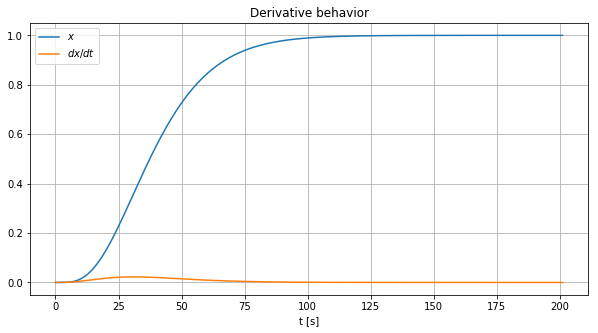

In [7]:
d4 = Derivator()

for sg in g4.x:
    d4(sg)
    
# Plot and decorations    
fig, ax = plt.subplots(figsize=(10,5))
pl=ax.plot(g4.t,g4.x,label='s4');  
pl=ax.plot(d4.t,d4.dx,label='d4');
ax.grid(True)
ax.set_title("Derivative behavior")
ax.legend([r"$x$",r"$dx/dt$"])
ax.set_xlabel("t [s]");

In [8]:
# %%writefile -a pid.py

class Integrator:
    def __init__(self):
        self.x = [0]
        self.ix = [0]
        self.T = TS 
        self.t = [0]       
    
    def integ(self,val):
        """
            Compute (x_k - x_{k-1})/T and updates the memory 
        """  
        integral = np.sum(self.T * np.array(self.x)) 
        self.x.append(val) # memory              
        self.ix.append(integral) # memory
        self.time_update()
        return self.ix[-1] 
    
    def time_update(self):
        """ time vector"""
        self.t.append(self.t[-1]+self.T)
    
    def __call__(self,val):
        """ Call like integ(error) """
        return self.integ(val)    
    

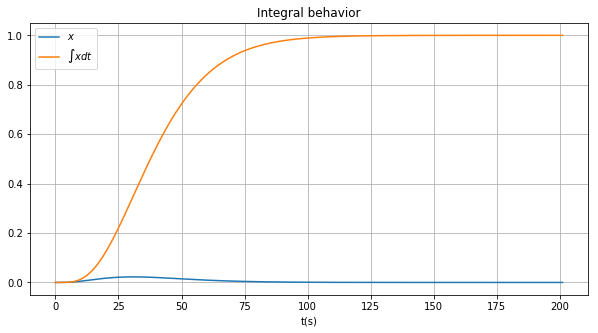

In [9]:
i4 = Integrator()

for sg in d4.dx:
    i4(sg)
    
fig, ax = plt.subplots(figsize=(10,5))    
ax.plot(d4.t,d4.dx,label='dx4');  
ax.plot(i4.t,i4.ix,label='i4');
ax.grid(True)
ax.set_title("Integral behavior")
ax.legend([r"$x$",r"$\int{x}dt$"]);
ax.set_xlabel("t(s)");

## Tunning a PID controller 

Here we propose the tunning of the controller via de Ziegler Nichols method. The objective is to find $K_u$ the maximum gain and $T_u$ the oscillation period of the closed loop. 

![](img/ziegler.png)


The main point of interest is when $K=4$ since the eigen values become imaginary meaning marginal stability

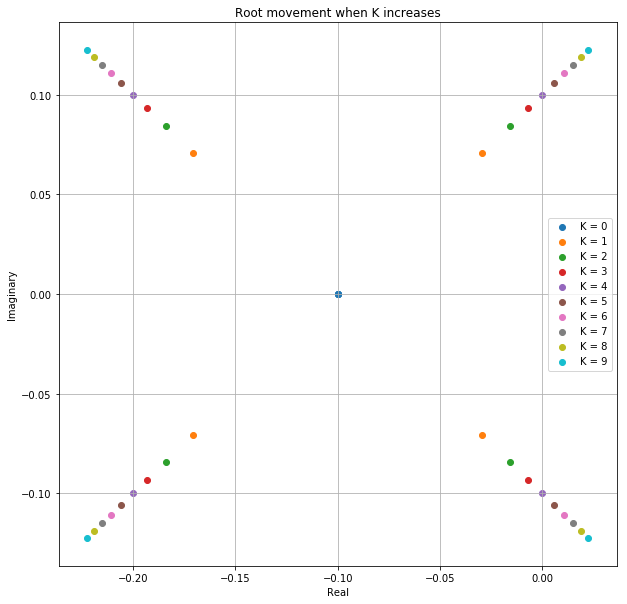

In [10]:
x = symbols('x')

# Root locus
# sys = cnt.tf([1],coeffs)
# cnt.rlocus(sys);

r_k = []

K =  range(0,10)

# This loop is to find the critical gain K_u

for k in K:
    pol = Poly(expand((10*x+1)**4+k),x)
    coeffs = [float(x) for x in pol.coeffs()]
    r_root = [np.real(v) for v in np.roots(coeffs)]
    i_root = [np.imag(v) for v in np.roots(coeffs)]    
    r_k.append((r_root,i_root))

pol = Poly(expand((10*x+1)**4+4),x)
coeffs = [float(x) for x in pol.coeffs()]
roots = np.roots(coeffs)
    
# Plot and decorations     
fig, ax = plt.subplots(figsize=(10,10)) 
for i,k in zip(r_k,K):
    x,y = i
    ax.scatter(x,y,label=f"K = {k}")
ax.set_title("Root movement when K increases")
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")
plt.grid(True)
plt.legend();


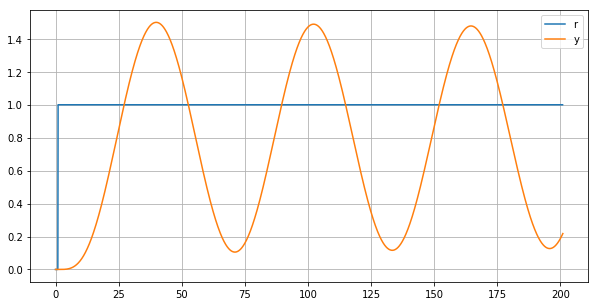

In [11]:
# System definition
g1,g2,g3,g4 = System(), System(), System(),System()

e = []
r = np.concatenate([np.zeros(10),np.ones(2000)])


for ct in r:
    err = ct - g4.x[-1]
    e.append(err)    
    uct = err*4
    g4(g3(g2(g1(uct))))

## Plot and values
tu = np.arange(0,(len(u))*TS,TS)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(tu,u,label='r');
ax.plot(g4.t,g4.x,label='y');
ax.grid(True,which="both")
ax.legend();    


By observation we infer the following values, $K_u$, $T_u$, and we can compute the constants for the PID. Check this link for more info [link](https://en.wikipedia.org/wiki/Ziegler–Nichols_method)

In [12]:
# # By observation 
K_u = 4 # Critical gain of oscillation 
T_u = 70 # By observation 

k_p = 0.3*K_u
k_i = 1.2*K_u/T_u
k_d = 3*K_u*T_u/40

print(f"K_p:{k_p}, K_i:{k_i} K_d:{k_d}")

K_p:1.2, K_i:0.06857142857142857 K_d:21.0


## Implementing a PID controller 

In the following the PID controller will be implemented. The idea is to explain the effects of saturations in the controller and how an antiwindup system may help for that. This full link explains the same idea but in MATLAB [link](https://www.mathworks.com/help/simulink/slref/anti-windup-control-using-a-pid-controller.html)

In [13]:
# %%writefile -a pid.py

class PID:

    def __init__(self, k_p=k_p,k_i=k_i,k_d=k_d):
        
        # Ziegler Nichols method 
        # Check here https://en.wikipedia.org/wiki/Ziegler–Nichols_method
        if k_d == 0:
            self.k_p = 0.45*K_u
            self.k_i = 0.54*K_u/T_u
            self.k_d = k_d
        else: 
            self.k_p = k_p
            self.k_i = k_i
            self.k_d = k_d
        
#         self.k_p = 0.3*K_u
#         self.k_i = 1.2*K_u/T_u
#         self.k_d = 3*K_u*T_u/40
        
        self.T = TS # Sampling time
        self.t = [0]
        
        self.u_p = [0]# Proportional term
        self.u_i = [0]# Integral term 
        self.u_d = [0] # Derivative term
        
        self.control = [0]# Control memory
        
        self.integ = Integrator()
        self.diff = Derivator()
        
        
    def apply_control(self,error):
        
        P = self.k_p * error
        self.u_p.append(P)
        I = self.k_i * self.integ(error)
        self.u_i.append(I)
        D = self.k_d * self.diff(error)
        self.u_d.append(D)
                             
        u_f = self.u_p[-1]+self.u_i[-1]+self.u_d[-1]
        self.time_update()
        self.control.append(u_f)
        return u_f
                        
    def time_update(self):
        """ time vector"""
        self.t.append(self.t[-1]+self.T)                        
                             
    def __call__(self,error):
        """ Callable """        
        return self.apply_control(error)
                             

### Testing the closed loop system

Let consider the case where a reference is constant and we implement a PI controller. The plots in the figure illustrate the performance of the closed loop system and the effects on the output of the controller and the proportional and integral terms 

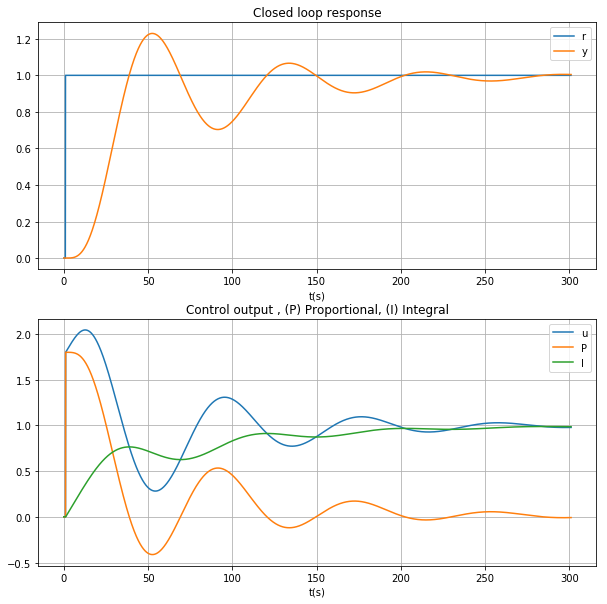

In [14]:
# System definition
pid = PID(k_d=0)
s1 = System()
s2 = System()
s3 = System()
s4 = System()

e = []
r = np.concatenate([np.zeros(10),np.ones(3000)])

for ct in r:
    err = ct - s4.x[-1]
    e.append(err)    
    uct = pid(err)
    s4(s3(s2(s1(uct))))
    
## Plot and values
tr = np.arange(0,(len(r))*TS,TS)
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(tr,r, label = "r");
ax[0].plot(s4.t,s4.x,label='y');
ax[0].grid(True,which="both")
ax[0].legend();    
ax[0].set_xlabel("t(s)");
ax[0].set_title("Closed loop response");

ax[1].plot(pid.t,pid.control, label = "u");
ax[1].plot(pid.t,pid.u_p, label = "P");
ax[1].plot(pid.t,pid.u_i, label = "I");
ax[1].grid(True,which="both");
ax[1].legend();    
ax[1].set_xlabel("t(s)");
ax[1].set_title("Control output , (P) Proportional, (I) Integral");
    

### Adding boundaries to the control signal 

In the following implementation the output of the controller will be bounded by introducing a saturation before applying to the control 

![](img/pid_sat.png)

In [15]:
# %%writefile -a pid.py

U_MAX = 10

class PIDlim:

    def __init__(self, k_p=k_p,k_i=k_i,k_d=k_d,u_max=U_MAX):
        
        # Ziegler Nichols method 
        # Check here https://en.wikipedia.org/wiki/Ziegler–Nichols_method
        if k_d == 0:
            self.k_p = 0.45*K_u
            self.k_i = 0.54*K_u/T_u
            self.k_d = k_d
        else: 
            self.k_p = k_p
            self.k_i = k_i
            self.k_d = k_d
        
#         self.k_p = 0.3*K_u
#         self.k_i = 1.2*K_u/T_u
#         self.k_d = 3*K_u*T_u/40
        
        self.T = TS # Sampling time
        self.t = [0]
        
        self.u_p = [0]# Proportional term
        self.u_i = [0]# Integral term 
        self.u_d = [0] # Derivative term
        
        self.u_max = u_max
        self.u_min = -u_max
        
        self.control = [0]# Control memory
        self.control_bnd = [0]
        
        self.integ = Integrator()
        self.diff = Derivator()
        
        
    def apply_control(self,error):
        
        P = self.k_p * error
        self.u_p.append(P)
        I = self.k_i * self.integ(error)
        self.u_i.append(I)
        D = self.k_d * self.diff(error)
        self.u_d.append(D)
                             
        u_f = self.u_p[-1]+self.u_i[-1]+self.u_d[-1]
        self.control.append(u_f)
        
        # Bound control 
        u_f = max(self.u_min,min(u_f,self.u_max))
        self.control_bnd.append(u_f)
        
        self.time_update()

        return u_f
                        
    def time_update(self):
        """ time vector"""
        self.t.append(self.t[-1]+self.T)                        
                             
    def __call__(self,error):
        """ Callable """        
        return self.apply_control(error)
                             

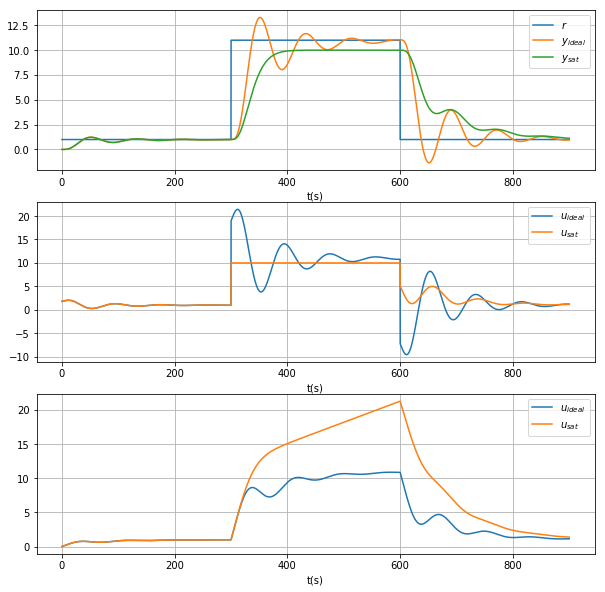

In [16]:
pid = PIDlim(k_d=0,u_max=10)
pid1 = PID(k_d=0)

s1,s2,s3,s4 = System(), System(),System(), System()
s5,s6,s7,s8 = System(), System(),System(), System()

e = []
A = 1
r = np.concatenate([A*np.ones(3000),(A+10)*np.ones(3000),A*np.ones(3000)])
tr = np.arange(0,(len(r))*TS,TS)

for ct in r:
    err = ct - s8.x[-1]
    e.append(err)    
    uct = pid(err)
    s8(s7(s6(s5(uct)))) # Series system 

for ct in r:
    err = ct - s4.x[-1]
    e.append(err)    
    uct = pid1(err)
    s4(s3(s2(s1(uct)))) # Series system 
    
## Plot and values

fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(tr,r, label = "r");
ax[0].plot(s4.t,s4.x,label='y1');
ax[0].plot(s8.t,s8.x,label='y2');
ax[0].grid(True,which="both")
ax[0].legend([r"$r$",r"$y_{ideal}$",r"$y_{sat}$"]);    
ax[0].set_xlabel("t(s)");

ax[1].plot(pid1.t[2:],pid1.control[2:], label = "u");
ax[1].plot(pid.t[1:],pid.control_bnd[1:], label = "ubd");
# # ax[1].plot(pid.t,pid.u_d, label = "D");
ax[1].grid(True,which="both")
ax[1].legend([r"$u_{ideal}$",r"$u_{sat}$"]);    
ax[1].set_xlabel("t(s)");

ax[2].plot(pid1.t[2:],pid1.u_i[2:], label = "u");
ax[2].plot(pid.t[2:],pid.u_i[2:], label = "ubd");
ax[2].grid(True,which="both")
ax[2].legend([r"$u_{ideal}$",r"$u_{sat}$"]);    
ax[2].set_xlabel("t(s)");

In particular when the change in the reference is very high. The integral term tends to cumulate the error and causing a loss in performance of the output one alternative is to implement a reset of the integrator. The objective will be to reset with a slow time constant via the mechanisms explained in the Amstrom book. 

![](img/pid-antiwindup.png)

In [17]:
# %%writefile -a pid.py

class PIDantiwindup:

    def __init__(self, k_p=k_p,k_i=k_i,k_d=k_d,u_max=U_MAX):
        
        # Ziegler Nichols method 
        # Check here https://en.wikipedia.org/wiki/Ziegler–Nichols_method
        if k_d == 0:
            self.k_p = 0.45*K_u
            self.k_i = 0.54*K_u/T_u
            self.k_d = k_d
        else: 
            self.k_p = k_p
            self.k_i = k_i
            self.k_d = k_d
        
#         self.k_p = 0.3*K_u
#         self.k_i = 1.2*K_u/T_u
#         self.k_d = 3*K_u*T_u/40
        
        self.T = TS # Sampling time
        self.t = [0]
        
        self.u_p = [0]# Proportional term
        self.u_i = [0]# Integral term 
        self.u_d = [0] # Derivative term
        
        self.u_max = u_max
        self.u_min = -u_max
        
        self.control = [0]# Control memory
        self.control_bnd = [0]
        
        self.T_t = 1 # Time constant for integration reset 
        
        self.integ = Integrator()
        self.diff = Derivator()
        
        
    def apply_control(self,error):
        
        P = self.k_p * error
        self.u_p.append(P)
        
        wind_reset = (self.control_bnd[-1] - self.control[-1])/self.T_t
        
        I = self.integ(self.k_i * error + wind_reset) # Anti windup mechanism
        
        self.u_i.append(I)
        D = self.k_d * self.diff(error)
        self.u_d.append(D)
                             
        u_f = self.u_p[-1]+self.u_i[-1]+self.u_d[-1]
        self.control.append(u_f)
        
        # Bound control 
        u_f = max(self.u_min,min(u_f,self.u_max))
        self.control_bnd.append(u_f)
        
        self.time_update()

        return u_f
                        
    def time_update(self):
        """ time vector"""
        self.t.append(self.t[-1]+self.T)                        
                             
    def __call__(self,error):
        """ Callable """        
        return self.apply_control(error)

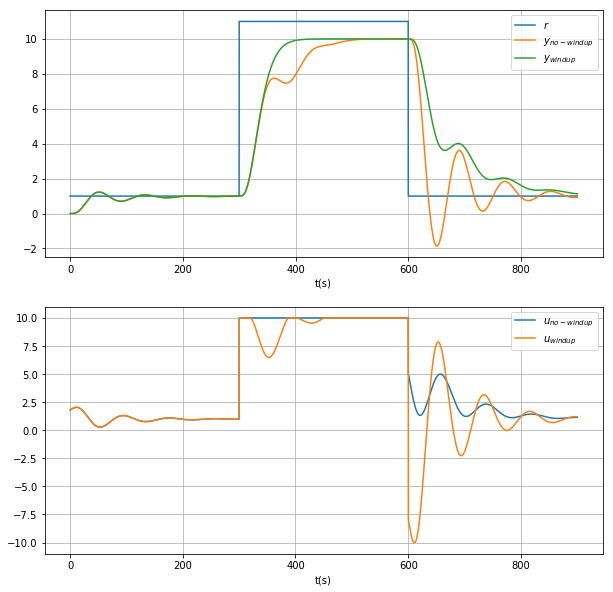

In [18]:
pid_sat = PIDlim(k_d=0,u_max=10)
pid_windup = PIDantiwindup(k_d=0,u_max=10)

s1,s2,s3,s4 = System(), System(),System(), System()
s5,s6,s7,s8 = System(), System(),System(), System()

e = []
A = 1
r = np.concatenate([A*np.ones(3000),(A+10)*np.ones(3000),A*np.ones(3000)])
tr = np.arange(0,(len(r))*TS,TS)

for ct in r:
    err = ct - s8.x[-1]
    e.append(err)    
    uct = pid_sat(err)
    s8(s7(s6(s5(uct)))) # Series system 

for ct in r:
    err = ct - s4.x[-1]
    e.append(err)    
    uct = pid_windup(err)
    s4(s3(s2(s1(uct)))) # Series system 
    
## Plot and values

fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(tr,r, label = "r");
ax[0].plot(s4.t,s4.x,label='y1');
ax[0].plot(s8.t,s8.x,label='y2');
ax[0].grid(True,which="both")
ax[0].legend([r"$r$",r"$y_{no-windup}$",r"$y_{windup}$"]);    
ax[0].set_xlabel("t(s)");

ax[1].plot(pid_sat.t[2:],pid_sat.control_bnd[2:], label = "usat");
ax[1].plot(pid_windup.t[1:],pid_windup.control_bnd[1:], label = "uwd");
# # ax[1].plot(pid.t,pid.u_d, label = "D");
ax[1].grid(True,which="both")
ax[1].legend([r"$u_{no-windup}$",r"$u_{windup}$"]);    
ax[1].set_xlabel("t(s)");

As observed the dynamical response of the system has less overshoot.